## Combi rna_S4_cluster_allcells_clean

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import os
import sys
from sklearn.linear_model import LogisticRegression

def MovePlots(plotpattern, subplotdir):
    if not os.path.exists(sc.settings.figdir+subplotdir):
        os.makedirs(sc.settings.figdir+subplotdir)
    os.system('mv '+sc.settings.figdir+'*'+plotpattern+'*.* '+sc.settings.figdir+'/'+subplotdir)

    
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = './figures/logregression'

sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable

-----
anndata     0.7.5
scanpy      1.7.1
sinfo       0.3.1
-----
PIL                 8.1.2
anndata             0.7.5
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
brotli              NA
cairo               1.20.0
certifi             2020.12.05
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.03.1
dateutil            2.8.1
decorator           4.4.2
fsspec              0.8.7
get_version         2.1
google              NA
h5py                3.1.0
idna                2.10
igraph              0.8.3
ipykernel           5.5.0
ipython_genutils    0.2.0
jedi                0.18.0
jinja2              2.11.3
joblib              1.0.1
json5               NA
jsonschema          3.2.0
jupyter_server      1.4.1
jupyterlab_server   2.3.0
kiwisolver          1.3.1
legacy_api_wrap     0.0.0


'/opt/conda/bin/python'

## Load test dataset/raw counts

In [2]:
adataTest=sc.read('S3_rna_cluster_annotate_1_clean.h5ad')

In [3]:
adataTest

AnnData object with n_obs × n_vars = 40654 × 34927
    obs: 'sample', 'stage', 'donor_id', 'percent_mito', 'n_counts', 'n_genes', 'batch', 'low_ncounts', 'high_mito', 'low_ncounts_high_mito', 'n_genes_by_counts', 'total_counts', 'total_counts_hum', 'pct_counts_hum', 'total_counts_pf', 'pct_counts_pf', 'stage_0', 'S_score', 'G2M_score', 'phase', 'scrublet_score', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'bonf_pval', 'is_doublet', 'is_doublet_0.05', 'sample_barcode', 'assignment', 'leiden', 'MFidentity', 'cluster'
    var: 'gene_ids', 'feature_types', 'n_cells', 'hum', 'pf', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'MFidentity_colors', 'assignment_colors', 'cluster_colors', 'donor_id_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'phase_colors', 'rank_genes_groups', 'sample_colors', 'stage_0_colors', 'stage_c

In [4]:
sc.pp.filter_genes(adataTest, min_cells=3)
sc.pp.normalize_per_cell(adataTest, counts_per_cell_after=1e4)
sc.pp.log1p(adataTest)
sc.pp.highly_variable_genes(adataTest, min_mean=0.0125, min_disp=0.25)
highly_variable_genes = adataTest.var["highly_variable"]
adataTest = adataTest[:, highly_variable_genes]
# sc.pp.scale(adata, max_value=10)
adataTest.X.shape

filtered out 18 genes that are detected in less than 3 cells
/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
normalizing by total count per cell
    finished (0:00:02): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(40654, 3938)

## Load reference data

In [5]:
adataRef = sc.read('/lustre/scratch117/cellgen/team292/rh26/10_exp_nuclei_temp/nS2_scVIintegrated_adata_latent30_cleanV4_fetal_raw.h5ad')

In [6]:
adataRef

AnnData object with n_obs × n_vars = 103716 × 31625
    obs: 'n_genes', 'sample', 'donor', 'termination', 'day', 'pcw', 'percent_mito', 'n_counts', 'batch', 'sample_barcode', 'souporcell_id', 'donor_deconv', 'donor_souporcell', 'scrublet_score', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'bonf_pval', 'is_doublet', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'leiden_pca', 'scrublet_doublet', 'leiden_scvi', 'celltype_predictions', 'probabilities', 'souporcell_MFgenotype', 'identity', 'souporcell_MFidentity'
    var: 'gene_ids-0', 'feature_types-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'n_cells-11', 'gene_ids-2', 'feature_types-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'n_cells-5', 'gene_ids-6', 'feature_types-6', 'n_cells-6', 'gene_ids-7', 'feature_typ

In [7]:
#adataRef = anndata.AnnData(X=np.expm1(adataRef.raw.X), var=adataRef.raw.var, obs=adataRef.obs, asview=False)
sc.pp.filter_genes(adataRef, min_cells=3)
sc.pp.normalize_per_cell(adataRef, counts_per_cell_after=1e4)
sc.pp.log1p(adataRef)
sc.pp.highly_variable_genes(adataRef, min_mean=0.0125, min_disp=0.25)
highly_variable_genes = adataRef.var["highly_variable"]
adataRef = adataRef[:, highly_variable_genes]
# sc.pp.scale(adata, max_value=10)
adataRef.X.shape

filtered out 368 genes that are detected in less than 3 cells
normalizing by total count per cell
    finished (0:00:04): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:09)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(103716, 5714)

### Add annotation

In [8]:
adataRef.obs['identity'].cat.categories

Index(['B cells', 'DC1', 'EVT', 'Endo f', 'Endo m', 'Epi 1', 'Epi 2', 'Ery',
       'F1', 'F2', 'GR', 'HBs', 'M3', 'M3_b', 'MO', 'PV', 'Ret', 'SCT',
       'T cells', 'Tregs', 'VCT', 'dM1', 'dM2', 'dNK1', 'dNK3', 'dS1', 'dS2',
       'dS3'],
      dtype='object')

In [9]:
adataRef.obs['identity_LR'] = adataRef.obs['identity']

Trying to set attribute `.obs` of view, copying.


### Filter common genes,  using either HVG overlap or non-HVG overlap

In [10]:
common_genes = list(set(adataRef.var.index.values).intersection(adataTest.var.index.values))
print('common genes: ', len(common_genes))
adataTest = adataTest[:,common_genes]
adataRef = adataRef[:,common_genes]
print(adataRef.X.shape)
print(adataTest.X.shape)

common genes:  2698
(103716, 2698)
(40654, 2698)


In [11]:
# list of genes shared data
# doing sorted on the overall list is VERY important for consistent ordering of the genes
common_genes = sorted(list(set(adataRef.var_names) & set(adataTest.var_names)))
print(len(common_genes),"genes are shared between annotated train and our joint data \n",
      len(set(adataRef.var_names)), 'genes in training data \n',
      len((set(adataTest.var_names))), 'genes in test joint data \n')

2698 genes are shared between annotated train and our joint data 
 2698 genes in training data 
 2698 genes in test joint data 



### Build a regression classifier from.. nS2_scVIintegrated_adata_latent30_cleanV4_fetal_raw.h5ad annotated ref dataset/ Elias-explants+day0

In [12]:
logisticRegr = LogisticRegression(max_iter = 2000, n_jobs = -1, random_state = 0, C=0.2)
logisticRegr.fit(adataRef.X, [str(i) for i in adataRef.obs['identity_LR'].values])

LogisticRegression(C=0.2, max_iter=2000, n_jobs=-1, random_state=0)

### Classify predictions in test samples

In [13]:
predictions = logisticRegr.predict(adataTest.X)
adataTest.obs['predictions'] = predictions
probabilities = logisticRegr.predict_proba(adataTest.X)
probs_adataTest = []
for i,clus in enumerate(adataTest.obs['predictions']):
    probs_adataTest.append(probabilities[i,logisticRegr.classes_==clus][0])

Trying to set attribute `.obs` of view, copying.


In [14]:
adataTest

AnnData object with n_obs × n_vars = 40654 × 2698
    obs: 'sample', 'stage', 'donor_id', 'percent_mito', 'n_counts', 'n_genes', 'batch', 'low_ncounts', 'high_mito', 'low_ncounts_high_mito', 'n_genes_by_counts', 'total_counts', 'total_counts_hum', 'pct_counts_hum', 'total_counts_pf', 'pct_counts_pf', 'stage_0', 'S_score', 'G2M_score', 'phase', 'scrublet_score', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'bonf_pval', 'is_doublet', 'is_doublet_0.05', 'sample_barcode', 'assignment', 'leiden', 'MFidentity', 'cluster', 'predictions'
    var: 'gene_ids', 'feature_types', 'n_cells', 'hum', 'pf', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'dispersions', 'dispersions_norm'
    uns: 'MFidentity_colors', 'assignment_colors', 'cluster_colors', 'donor_id_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'phase_colors', 'rank_genes_gro

... storing 'predictions' as categorical


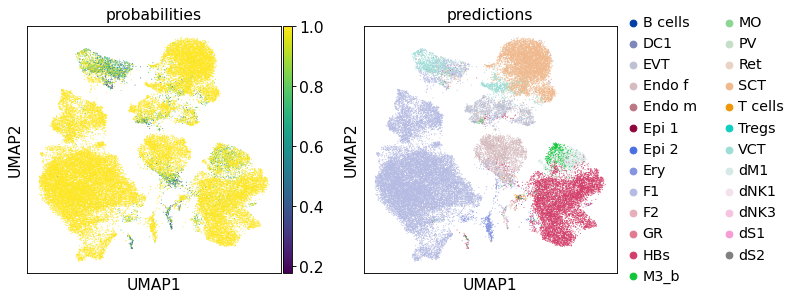

In [15]:
adataTest.obs['probabilities'] = probs_adataTest
#pf_adata.obsm["X_umap"] = pf_adataP.obsm["X_umap_noDiff"]
adataTest.obsm["X_umap"] =adataTest.obsm["X_umap"]
sc.pl.umap(adataTest, color=['probabilities', 'predictions' ])

In [16]:
adataTest.raw = adataTest.copy()

In [17]:
adataTest.X.shape

(40654, 2698)

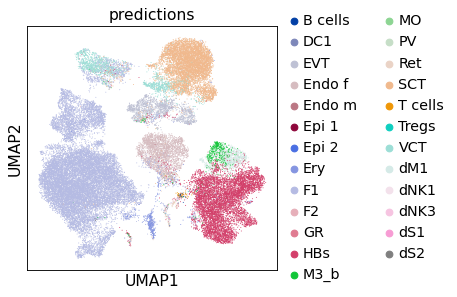

In [18]:
sc.pl.umap(adataTest, color='predictions', legend_fontoutline=2,save='_logreg_from_explants_elias.pdf')

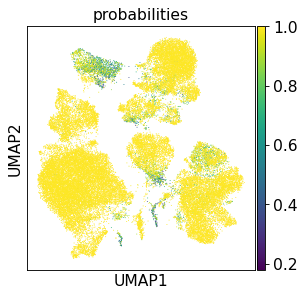

In [19]:
sc.pl.umap(adataTest, color=['probabilities'],save='_logreg_probabilities_from_explants_elias.pdf')

In [20]:
adataTest.write('S4_rna_logregression_annotate_1_clean.h5ad')
adataTest.X.shape

(40654, 2698)

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


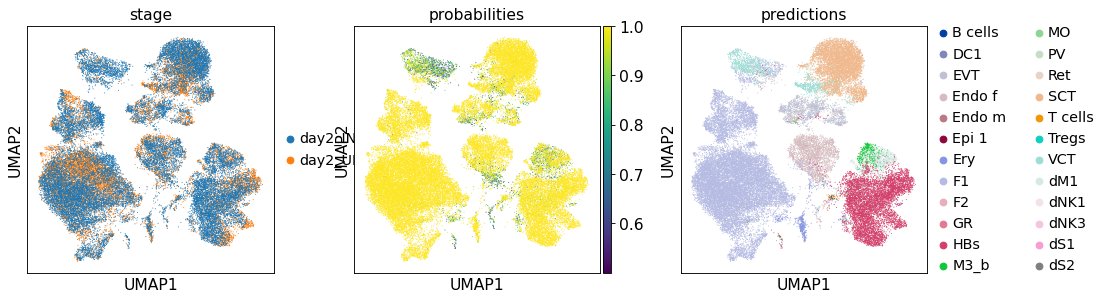

In [21]:
sc.pl.umap(adataTest[[ i > 0.5 for i in adataTest.obs['probabilities']  ]], color=['stage', 'probabilities', 'predictions' ])

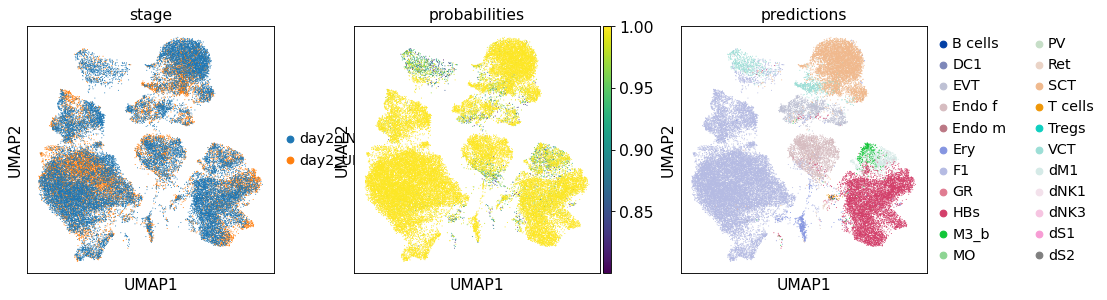

In [22]:
sc.pl.umap(adataTest[[ i > 0.8 for i in adataTest.obs['probabilities']  ]], color=['stage', 'probabilities', 'predictions' ])

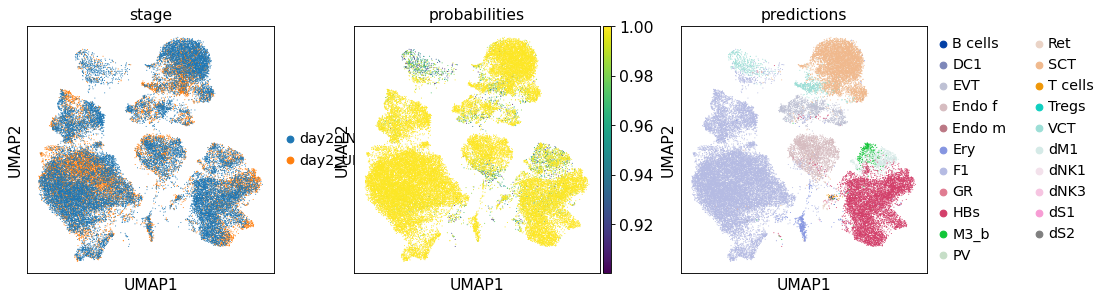

In [23]:
sc.pl.umap(adataTest[[ i > 0.9 for i in adataTest.obs['probabilities']  ]], color=['stage', 'probabilities', 'predictions' ])

## 